# TOP

In [4]:
import functools
import itertools
import pickle

import cmocean
import cmocean.cm as cmo
import matplotlib as mpl
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import polars as pl
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.signal as signal
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import pickle
from tqdm.notebook import tqdm

from flexfrac1d.model.model import Ice, FloatingIce, Floe, Ocean, DiscreteSpectrum, WavesUnderFloe, WavesUnderIce
from flexfrac1d.lib.physics import EnergyHandler, StrainHandler, FluidSurfaceHandler
from flexfrac1d.model.frac_handlers import BinaryFracture, BinaryStrainFracture, MultipleStrainFracture


# \textwidth := 177 mm approx 6.97 in
# \columnsep := 7 mm approx -> \colwidth approx 3.35 in
WIDTH_TWO_COLUMNS = 3.0
WIDTH_SINGLE_COLUMN = 6.3
GR = (1 + 5**.5) / 2

In [5]:
import lib.lib
import importlib
importlib.reload(lib.lib)
from lib.lib import (
    make_parameters,
    compute_split,
    compute_dissipation_length,
    threshold_search,
    calc_energy_if_frac,
    colours
)

# Reference

In [6]:
gravity, tank_params, varnish_params = make_parameters()

varnish = Ice(**varnish_params)
tank = Ocean(**tank_params)
floating_varnish = FloatingIce.from_ice_ocean(ice=varnish, ocean=tank, gravity=gravity)
flexural_length = floating_varnish.elastic_length

path = "results/stationnary_simple_comparison.npz"
loaded = np.load(path)

(
    wavenumbers,
    amplitude_thresholds,
    curvature_thresholds,
    normalised_fractures,
    curvatures_at_half_point,
    normalised_max_curvature_coords,
    max_curvatures,
    relaxation_lengths,
) = (
    loaded[k] for k in (
        "wavenumbers",
        "amplitude_thresholds",
        "curvature_thresholds",
        "normalised_fractures",
        "curvatures_at_half_point",
        "normalised_max_curvature_coords",
        "max_curvatures",
        "relaxation_lengths",
    )
)
nondim = flexural_length * wavenumbers

## Find jumps

In [19]:
jumps = (0.16377908749808165, 0.32747379468172555, 0.7578364902291609)

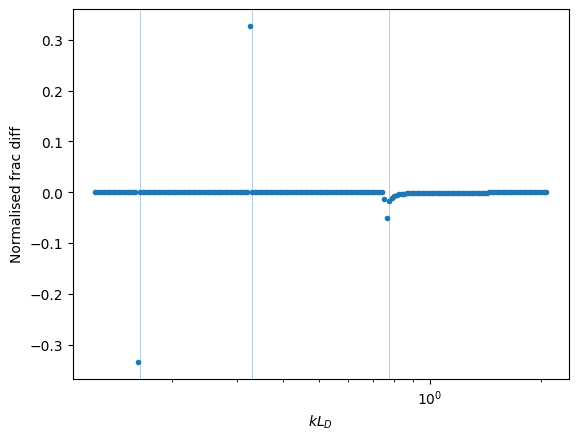

In [18]:
# Fracture au max à approx 1/2
# Fracture au max à approx 1/6
# Fracture au max à 1/2
# Fracture décorrelée du max

_y = normalised_fractures.copy()
_m = _y > (.5 + 1e-6)
_y[_m] = 1 - _y[_m]

obj = np.ediff1d(_y)**2
# obj /= nondim[:-1]
obj /= np.nanmax(obj)

peaks = signal.find_peaks(obj, height=1e-6)[0]

jump_idxs = peaks + 1
_jumps = nondim[jump_idxs]

plt.semilogx(nondim[:-1], np.ediff1d(_y), ".")
for _j in _jumps:
    plt.axvline(_j, lw=.5, alpha=.5)
plt.xlabel("$kL_D$")
plt.ylabel("Normalised frac diff")
# plt.axvline(nondim[144])
# plt.axvline(nondim[145])

plt.show()
plt.close()

In [388]:
phase = 0
fracture_handler = BinaryFracture()
idx = jump_idxs[0]
bounds = wavenumbers[[idx - 1, idx + 1]]
prev_bounds = wavenumbers[[idx - 2, idx + 2]]
_n = 0
th = 1e-7

_n = 0
while True:
    _a, _b = bounds
    _wuis = [WavesUnderIce(floating_varnish, np.atleast_1d(_k), 0) for _k in bounds]
    _lengths = harmonic_number * np.pi / bounds
    _a_thresholds = (
        threshold_search(
            wui=_wui,
            length=_length,
            fracture_handler=fracture_handler,
        )[0] for _wui, _length in zip(_wuis, _lengths)
    )
    splits = (compute_split(_a, phase, _wui, _length, fracture_handler) for _a, _wui, _length in zip(_a_thresholds, _wuis, _lengths))
    curv_a, curv_b = (split[1].curvature(split[0], None, True, None) for split in splits)
    if curv_a * curv_b < 0:
        prev_bounds[:] = bounds[:]
        bounds = np.array((_a**2 * _b, _a * _b**2))**(1/3)
    elif curv_a < 0:
        prev_bounds[1], bounds[1] = bounds[1], bounds[0]
        bounds[0] = prev_bounds[0]
    elif curv_b > 0:
        prev_bounds[0], bounds[0] = bounds[0], bounds[1]
        bounds[1] = prev_bounds[1]
    else:
        raise ValueError
    if np.ediff1d(bounds) * flexural_length < th:
        break
    if _n > 50:
        break
    _n += 1
    if _n % 5 == 0:
        print(f"{_n: 3d} iterations")
jump0 = bounds[1] * flexural_length

  5 iterations
 10 iterations
 15 iterations


In [389]:
idx = jump_idxs[1]
bounds = wavenumbers[[idx - 1, idx + 1]]
prev_bounds = wavenumbers[[idx - 2, idx + 2]]
_n = 0
while True:
    _a, _b = bounds
    _wuis = [WavesUnderIce(floating_varnish, np.atleast_1d(_k), 0) for _k in bounds]
    _lengths = harmonic_number * np.pi / bounds
    _a_thresholds = (
        threshold_search(
            wui=_wui,
            length=_length,
            fracture_handler=fracture_handler,
        )[0] for _wui, _length in zip(_wuis, _lengths)
    )
    splits = (compute_split(_a, phase, _wui, _length, fracture_handler) for _a, _wui, _length in zip(_a_thresholds, _wuis, _lengths))
    curv_a, curv_b = (split[1].curvature(split[0], None, True, None) for split in splits)
    if curv_a * curv_b < 0:
        prev_bounds[:] = bounds[:]
        bounds = np.array((_a**2 * _b, _a * _b**2))**(1/3)
    elif curv_a > 0:
        prev_bounds[1], bounds[1] = bounds[1], bounds[0]
        bounds[0] = prev_bounds[0]
    elif curv_b < 0:
        prev_bounds[0], bounds[0] = bounds[0], bounds[1]
        bounds[1] = prev_bounds[1]
    else:
        raise ValueError
    if np.ediff1d(bounds) * flexural_length < th:
        break
    if _n > 50:
        break
    _n += 1
    if _n % 5 == 0:
        print(f"{_n: 3d} iterations")
jump1 = bounds[1] * flexural_length

  5 iterations
 10 iterations
 15 iterations


In [386]:
idx = jump_idxs[2]
bounds = wavenumbers[[idx - 1, idx + 1]]
# prev_bounds = wavenumbers[[idx - 2, idx + 2]]
_n = 0
_a, _b = bounds
th = 1e-7
while True:
    midpoint = np.sqrt(_a * _b)
    
    _wui = WavesUnderIce(floating_varnish, np.atleast_1d(midpoint), 0)
    _length = harmonic_number * np.pi / midpoint
    _a_thresholds = threshold_search(
        wui=_wui,
        length=_length,
        fracture_handler=fracture_handler,
    )[0]
    _x1 = compute_split(
        _a_thresholds,
        phase,
        _wui,
        _length,
        fracture_handler
    )[0]

    if np.allclose(_x1 - .5, 0):
        _a = midpoint
    else:
        _b = midpoint

    if (_b - _a) * flexural_length < th:
        break
    if _n > 50:
        break
    _n += 1
    if _n % 5 == 0:
        print(f"{_n: 3d} iterations")
jump2 = _b * flexural_length

  5 iterations
 10 iterations
 15 iterations


In [390]:
# KEEP OUTPUT
jump0, jump1, jump2

(0.16377908749808165, 0.32747379468172555, 0.7578364902291609)

In [392]:
jumps = jump0, jump1, jump2

In [393]:
np.ediff1d(jumps)

array([0.16369471, 0.4303627 ])

In [306]:
# splits = (compute_split(_a, phase, _wui, _length, fracture_handler) for _a, _wui, _length in zip(_a_thresholds, _wuis, _lengths))
# gen = (split[1].curvature(split[0], None, True, None) for split in splits)

## Helper figures

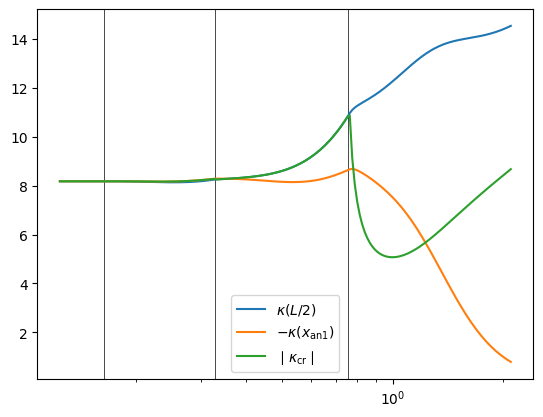

In [10]:
plt.semilogx(nondim, curvatures_at_half_point, label=r"$\kappa(L/2)$")
plt.semilogx(nondim, np.abs(max_curvatures), label=r"$-\kappa(x_{\mathrm{an1}})$")
plt.semilogx(nondim, np.abs(curvature_thresholds), label=r"$\mid\kappa_{\mathrm{cr}}\mid$")
for jump in jumps:
    plt.axvline(jump, c="k", zorder=-10, lw=.5)
plt.legend()
plt.show()
plt.close()

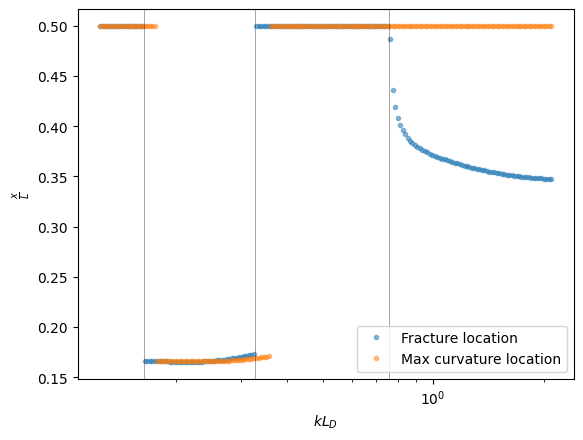

In [11]:
yy = normalised_fractures.copy()
mask = yy > .5
yy[mask] = 1 - yy[mask]
yb = normalised_max_curvature_coords.copy()
yb[curvatures_at_half_point > np.abs(max_curvatures)] = .5
plt.plot(nondim, yy, ".", alpha=.5, label="Fracture location")
plt.plot(nondim, yb, ".", alpha=.5, label="Max curvature location")
for jump in jumps:
    plt.axvline(jump, c="k", alpha=.5, lw=.5)
plt.xscale("log")
plt.xlabel("$k L_D$")
plt.ylabel(r"$\frac{x}{L}$")
plt.legend()
plt.show()
plt.close()

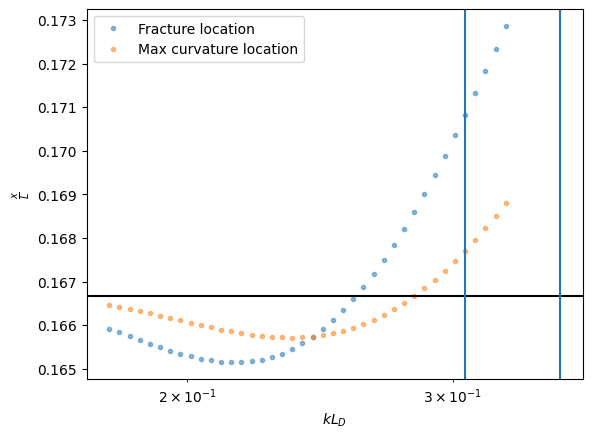

In [12]:
mask = (nondim >= jumps[0]) & (nondim < nondim[117])
mask = (nondim > nondim[71]) & (nondim < jumps[1])
plt.plot(nondim[mask], yy[mask], ".", alpha=.5, label="Fracture location")
plt.plot(nondim[mask], yb[mask], ".", alpha=.5, label="Max curvature location")
plt.axhline(1/6, c="k")
plt.xscale("log")
plt.xlabel("$k L_D$")
plt.ylabel(r"$\frac{x}{L}$")

plt.axvline(.3057)
plt.axvline(2**-1.5)

plt.legend()
plt.show()
plt.close()

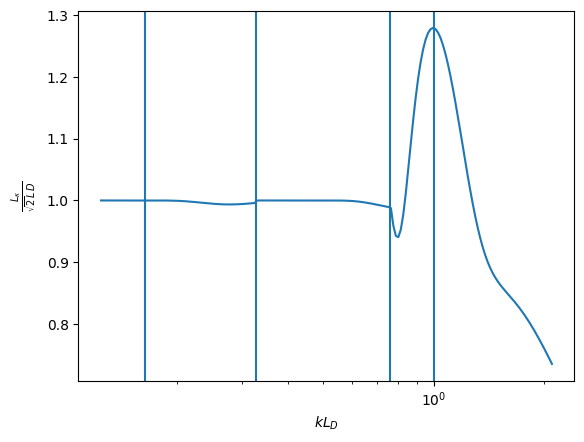

In [13]:
plt.semilogx(
    nondim, relaxation_lengths / (2**.5 * flexural_length),
)
for jump in jumps:
    plt.axvline(jump)
plt.xlabel("$k L_D$")
plt.ylabel(r"$\frac{L_\kappa}{\sqrt{2}L_ D}$")
plt.axvline(1)
plt.show()
plt.close()

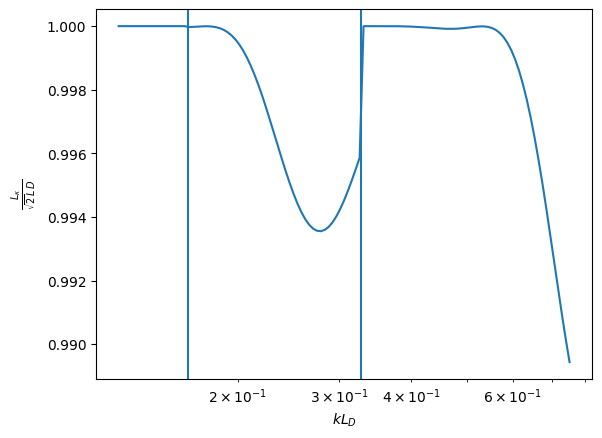

In [14]:
mask = nondim < jumps[-1]
plt.semilogx(
    nondim[mask], relaxation_lengths[mask] / (2**.5 * flexural_length)
)
for jump in jumps[:-1]:
    plt.axvline(jump)

plt.xlabel("$k L_D$")
plt.ylabel(r"$\frac{L_\kappa}{\sqrt{2}L_ D}$")
plt.show()
plt.close()

## Energy test

In [488]:
wave_energy = .5 * tank.density * gravity * amplitude_thresholds**2 * lengths

In [500]:
elastic_energy = np.array(
    [
        WavesUnderFloe(
            left_edge=0,
            length=_L,
            wui=WavesUnderIce(floating_varnish, np.atleast_1d(_k), 0),
            edge_amplitudes=np.atleast_1d(_a),
        ).energy(None, True, None)
        for _k, _L, _a in zip(wavenumbers, lengths, amplitude_thresholds)
    ]
) * floating_varnish.thickness

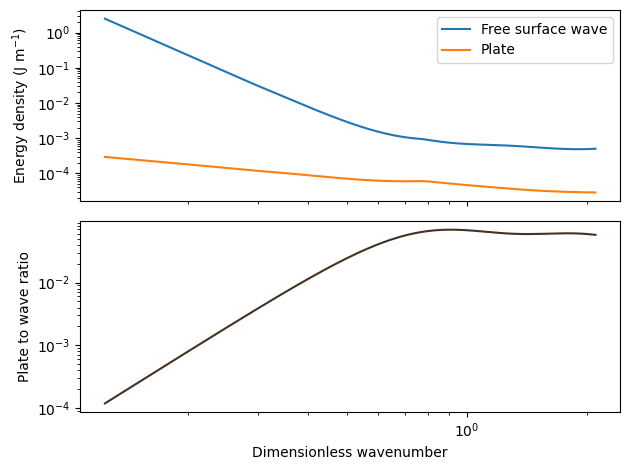

In [874]:
fig, (axt, axb) = plt.subplots(2, sharex=True)

axt.loglog(nondim, wave_energy, label="Free surface wave")
axt.loglog(nondim, elastic_energy, label="Plate")
axt.set_ylabel("Energy density (J m$^{-1}$)")
axt.legend()

axb.loglog(nondim, elastic_energy / wave_energy, c="#432")
axb.set_xlabel("Dimensionless wavenumber")
axb.set_ylabel("Plate to wave ratio")

fig.tight_layout()
plt.show()
plt.close()

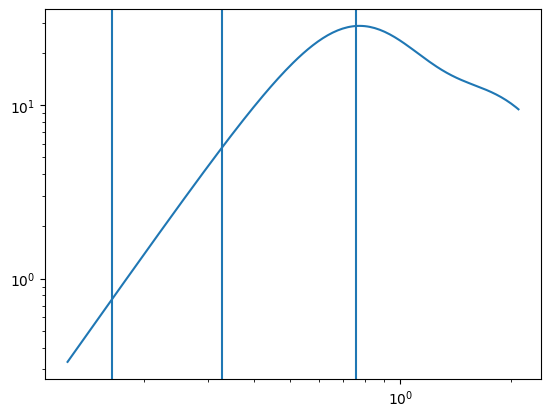

In [521]:

plt.plot(nondim, elastic_energy / amplitude_thresholds**2, label="Plate")
# plt.legend()
# plt.xlabel("Dimensionless wavenumber")
# plt.ylabel("Energy density (J m$^{-1}$)")
# plt.axline((0, 0), slope=1)
for jump in jumps:
    plt.axvline(jump)
plt.loglog()
plt.show()
plt.close()

## Figure

In [20]:
def _fun(ax, xvals, yvals):
    ax.plot(xvals, yvals, "C3", lw=lw)
    

jumps = (0.16377908749808165, 0.32747379468172555, 0.7578364902291609)
_y = normalised_fractures.copy()
_m = _y > (.5 + 1e-6)
_y[_m] = 1 - _y[_m]

base_triangle_y = amplitude_thresholds[jump_idxs[1]]
ratio = 3  # ratio gives how many centred triangles would fit, in logspace, between the two jumps
base_triangle_x0, base_triangle_x1 = np.exp(np.linalg.solve(
    [[-1, 1], [1, 1]],
    [
        np.log(jumps[1] / jumps[0]) / ratio,
        np.log(jumps[1] * jumps[0]),
    ],
))
top_triangle_y = base_triangle_y * (base_triangle_x1 / base_triangle_x0)**2

y_lim = .1, 2.5
boundaries = np.array((y_lim[0], *jumps, y_lim[1]))
middles = np.sqrt(boundaries[:-1] * boundaries[1:])
middles

array([0.1279762 , 0.23158877, 0.49816824, 1.37644151])

[1.6182466915860025, 1.6182466915860025, 1.6182466915860025, 1.6182466915860025]


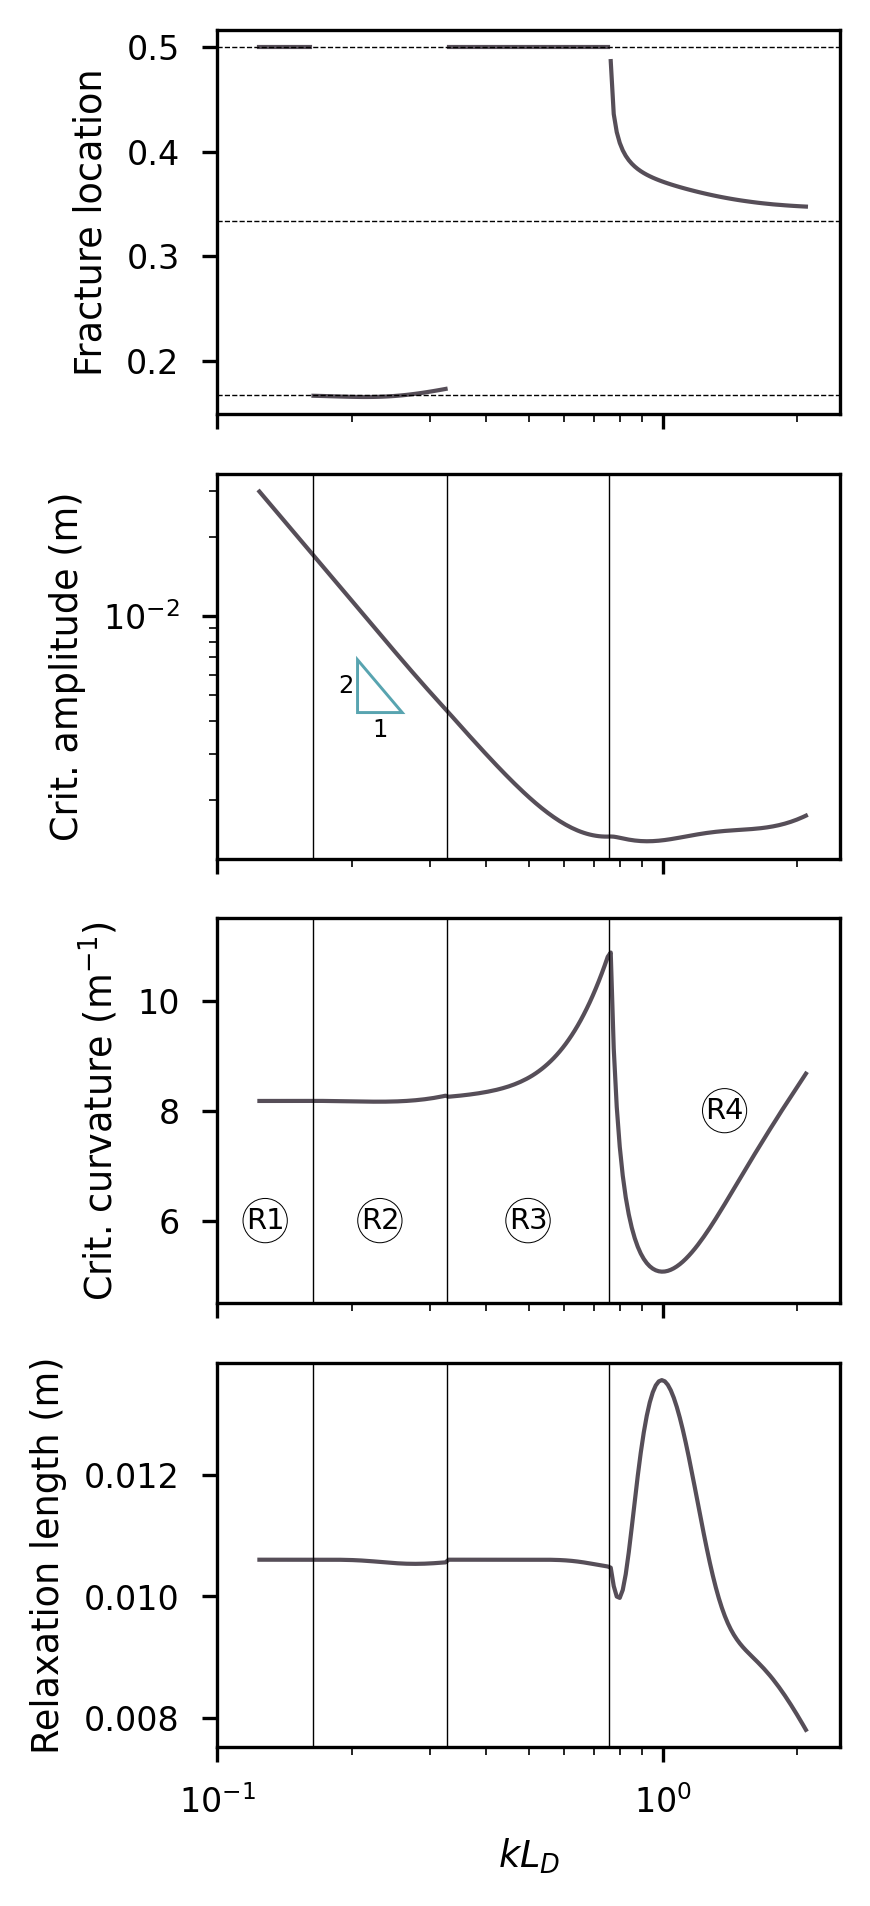

In [21]:
nondim = wavenumbers * flexural_length
width = WIDTH_TWO_COLUMNS
height = width / GR * 3.481
lw = 1

with plt.style.context("seaborn-v0_8-paper"), sns.color_palette(colours):
    fig, axes = plt.subplots(4, dpi=300, figsize=(width, height), sharex=True)

    ax = axes[0]
    bounds = 0, *jumps, np.inf
    for lb, ub in zip(bounds[:-1], bounds[1:]):
        mask = (nondim >= lb) & (nondim < ub)
        ax.semilogx(nondim[mask], _y[mask], "C3", lw=lw)
    ax.set_ylabel("Fracture location")

    for val in (1 / 6, 1 / 3, 1 / 2):
        ax.axhline(val, c="k", lw=lw / 3, ls="--")
    
    ax = axes[1]
    _fun(ax, nondim, amplitude_thresholds)
    ax.add_patch(   
        plt.Polygon(
            (
                (base_triangle_x0, base_triangle_y),
                (base_triangle_x1, base_triangle_y),
                (base_triangle_x0, top_triangle_y),
            ),
            facecolor="#0000",
            edgecolor="C0",
            lw=lw / 2**.5,
            )
    )
    ax.text(
        np.sqrt(base_triangle_x0 * base_triangle_x1),
        base_triangle_y - 2e-4,
        "1",
        ha="center",
        va="top",
        fontsize="xx-small",
    )
    ax.text(
        base_triangle_x0 - 4e-3,
        np.sqrt(base_triangle_y * top_triangle_y),
        "2",
        ha="right",
        va="center",
        fontsize="xx-small",
    )
    ax.set_yscale("log")
    ax.set_ylabel("Crit. amplitude (m)")
    # ax.set_ylim(1e-3, 3e-2)

    ax = axes[2]
    _fun(ax, nondim, np.abs(curvature_thresholds))
    # ax.set_ylabel(r"$\kappa_\mathrm{cr}$ (m$^{-1}$)")
    for region_num, x_coord in zip(range(1, 5), middles):
        y_coord = 6 if region_num <= 3 else 8
        ax.annotate(
            f"R{region_num}",
            (x_coord, y_coord),
            # xycoords="figure fraction",
            bbox={"boxstyle" : "circle", "facecolor": "#0000", "pad": .1},
            ha="center",
            va="center",
            fontsize="x-small",
        )
    ax.set_ylabel("Crit. curvature (m$^{-1}$)")
    ax.set_ylim(4.5, 11.5)

    ax = axes[3]
    _fun(ax, nondim, relaxation_lengths)
    ax.set_ylabel("Relaxation length (m)")
    
    for ax in axes[1:]:
        for jump in jumps:
            ax.axvline(jump, c="k", lw=lw / 3)

    ax.set_xlabel("$k L_D$")
    ax.set_xlim(.1, 2.5)
    
    fig.tight_layout()
    # fig.savefig("simple_example.pdf", dpi=fig.dpi, bbox_inches="tight")
    print([ax.bbox.width / ax.bbox.height for ax in axes])

    plt.show()
    plt.close()

## Test fit

In [624]:
mn, mx = nondim[~np.isnan(amplitude_thresholds)][[0, -1]]
bounds = np.array((mn, *jumps, mx))
midpoints = np.sqrt(bounds[:-1] * bounds[1:]) / flexural_length

In [717]:
mask = (nondim > jump1) & (nondim < jump2)
# mask = (nondim < jump0) & ~np.isnan(amplitude_thresholds)
endog = amplitude_thresholds[mask]
x = nondim[mask]
exog = sm.add_constant(np.vstack((x**-2, x**2)).T)
fit = sm.OLS(endog, exog).fit()

fit.params

array([-0.00021066,  0.00047678,  0.00143711])

In [720]:
Xvals = fit.params * fit.model.exog

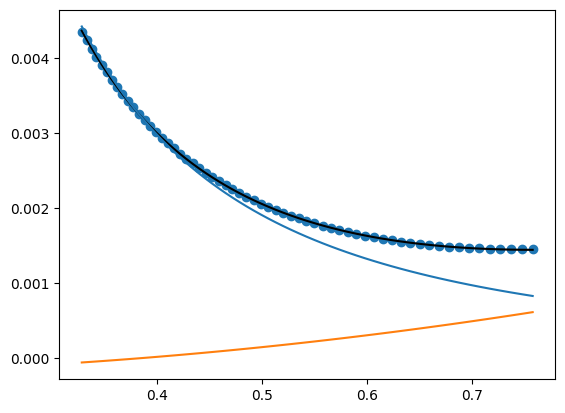

In [722]:
plt.scatter(x, endog)
plt.plot(x, fit.fittedvalues, "k")
plt.plot(x, Xvals[:, 1])
plt.plot(x, Xvals[:, 0] + Xvals[:, 2])
plt.show()
plt.close()

# 4 panels

## Free energy, curvature

In [25]:
harmonic_number = 3
lengths = harmonic_number * np.pi / wavenumbers

fracture_handler = BinaryFracture()
mn, mx = np.nonzero(~np.isnan(amplitude_thresholds))[0][[0, -1]]
idxs = np.array((mn, *jump_idxs, mx))
mid_idxs = (idxs[:-1] + idxs[1:]) //2

In [26]:
for ax, tax, idx in zip(np.ravel(axes), twin_axes, mid_idxs):
    wui = WavesUnderIce(floating_varnish, np.atleast_1d(wavenumbers[idx]), 0)
    _w = WavesUnderFloe(left_edge=0, length=lengths[idx], wui=wui, edge_amplitudes=np.atleast_1d(amplitude_thresholds[idx]))
    diag = fracture_handler.diagnose(_w, res=_w.length / 200, an_sol=True)
    print((diag.energy.sum(axis=1)- diag.initial_energy).min())

-0.17385085281188095
-0.1738516362678164
-0.17385733570825807
-0.17383991184551004


In [63]:
for i, idx in enumerate(mid_idxs):
    wui = WavesUnderIce(floating_varnish, np.atleast_1d(wavenumbers[idx]), 0)
    _w = WavesUnderFloe(
        left_edge=0, length=lengths[idx], wui=wui, edge_amplitudes=np.atleast_1d(amplitude_thresholds[idx])
    )
    diag = fracture_handler.diagnose(_w, res=_w.length / 200, an_sol=True)

    np.savez(
        f"quad_{i}.npz",
        x=diag.x / lengths[idx],
        free_energy=diag.energy.sum(axis=1) + diag.frac_energy_rate - diag.initial_energy,
        curvature=_w.curvature(diag.x, None, True, None),
        conforming_curvature=(
            -amplitude_thresholds[idx]
            * wavenumbers[idx]**2
            / (1 + nondim[idx]**4)
            * np.sin(wavenumbers[idx] * diag.x)
        )
    )

np.savetxt("nondim_wavenumbers.csv", nondim[mid_idxs], delimiter=",")
np.savetxt("normalised_fractures.csv", normalised_fractures[mid_idxs], delimiter=",")

[1.6180478993078957, 1.6180478993078953, 1.6180478993078957, 1.6180478993078953]


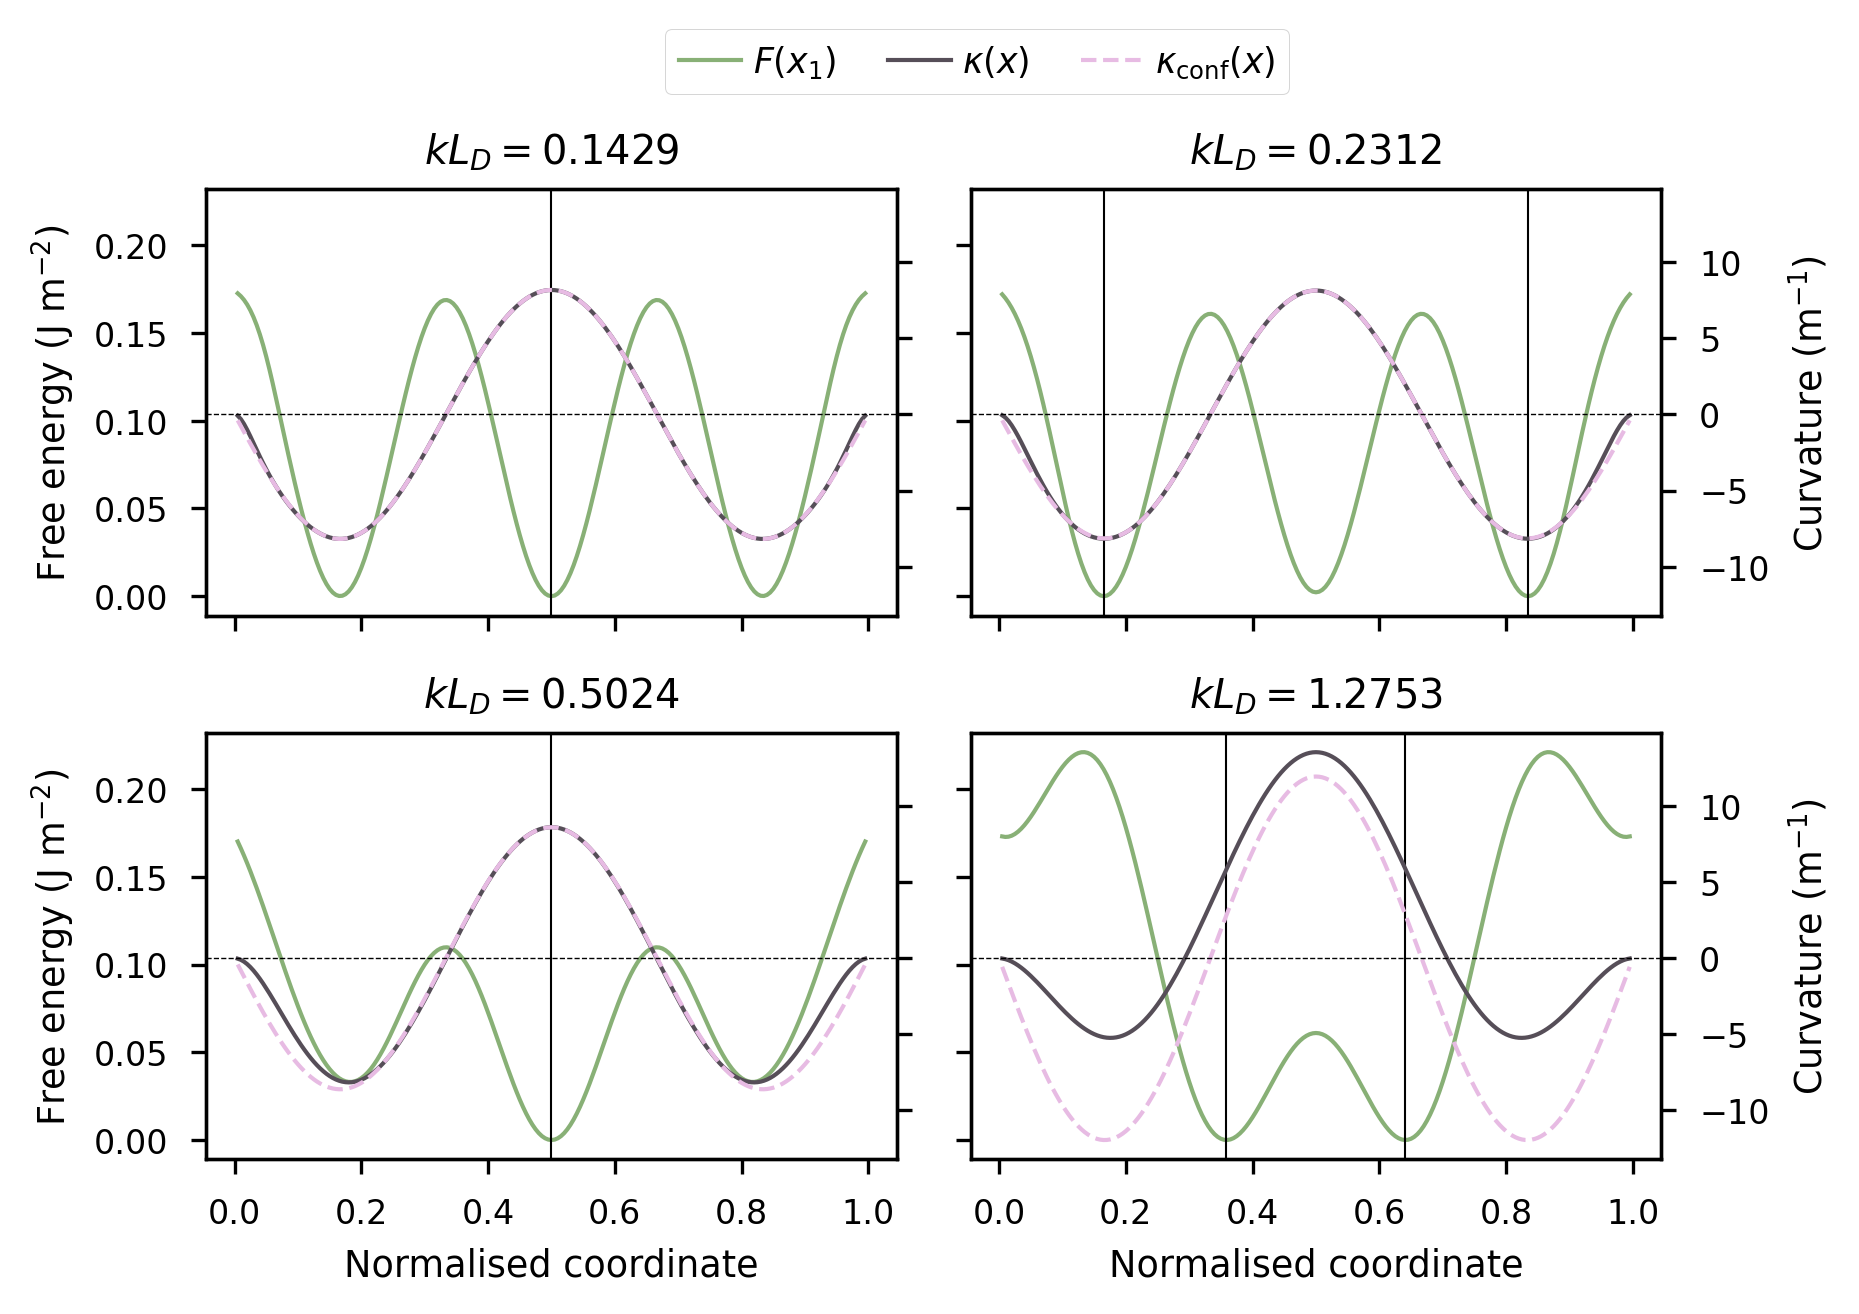

In [27]:
width = WIDTH_SINGLE_COLUMN
height = width / GR / .940
lw = 1

with plt.style.context("seaborn-v0_8-paper"), sns.color_palette(colours):
    fig, axes = plt.subplots(2, 2, dpi=300, sharex=True, sharey=True, figsize=(width, height))
    
    twin_axes = [ax.twinx() for ax in np.ravel(axes)]
    for tax0, tax1 in zip(twin_axes[:-1], twin_axes[1:]):
        tax0.sharey(tax1)
    
    for ax, tax, idx in zip(np.ravel(axes), twin_axes, mid_idxs):
        wui = WavesUnderIce(floating_varnish, np.atleast_1d(wavenumbers[idx]), 0)
        _w = WavesUnderFloe(left_edge=0, length=lengths[idx], wui=wui, edge_amplitudes=np.atleast_1d(amplitude_thresholds[idx]))
        diag = fracture_handler.diagnose(_w, res=_w.length / 200, an_sol=True)
        
        ax.plot(
            diag.x / lengths[idx],
            (diag.energy.sum(axis=1) + diag.frac_energy_rate) - diag.initial_energy,
            "C2",
            lw=lw,
            label=r"$F(x_1)$"
        )
        ax.axvline(normalised_fractures[idx], lw=lw / 2, c="k")
        if not np.isclose(normalised_fractures[idx] - .5, 0):
            ax.axvline(1 - normalised_fractures[idx], lw=lw / 2, c="k")
            
        tax.plot(
            diag.x / lengths[idx], _w.curvature(diag.x, None, True, None), "C3",
            label=r"$\kappa(x)$",
            lw=lw,
        )
        tax.plot(
            diag.x  / lengths[idx],
            -amplitude_thresholds[idx]
            * wavenumbers[idx]**2
            / (1 + nondim[idx]**4)
            * np.sin(wavenumbers[idx] * diag.x),
            "C4--",
            lw=lw,
            # label=r"$-\frac{ak^2}{1 + {(k L_D)}^4}\sin(kx)$",
            label=r"$\kappa_{\mathrm{conf}}(x)$"
        )
        tax.axhline(0, c="k", lw=lw / 3, ls="--")
        ax.set_title(f"$k L_D = {{{nondim[idx]:1.4f}}}$")
    
    for tax in twin_axes[::2]:
        plt.setp(tax.get_yticklabels(), visible=False)

    for ax in axes[1, :]:
        ax.set_xlabel("Normalised coordinate")
    for ax in axes[:, 0]:
        ax.set_ylabel("Free energy (J m$^{-2}$)")
    for tax in twin_axes[1::2]:
        tax.set_ylabel("Curvature (m$^{-1}$)")
    # axes[0, 0].set_ylim(-.19, 0.01)
    # twin_axes[0].set_ylim(-15, 15)

    handles, labels = zip(ax.get_legend_handles_labels(), tax.get_legend_handles_labels())
    handles, labels = (itertools.chain(*_e) for _e in (handles, labels))
    
    plt.figlegend(
        handles=handles,
        labels=labels,
        ncols=3,
        handlelength=1.8,
        loc="upper center",
        fontsize="small",
        bbox_to_anchor=(.525, 1.06),
        handletextpad=.33,
        columnspacing=1.5,
    )
    
    fig.tight_layout()
    print([ax.bbox.width / ax.bbox.height for ax in np.ravel(axes)])

    # fig.savefig("different_regions.pdf", bbox_inches="tight", dpi=fig.dpi)
        
    plt.show()
    plt.close()

## Deflection

[1.6179487508454442, 1.6179487508454444, 1.6179487508454446, 1.6179487508454449]


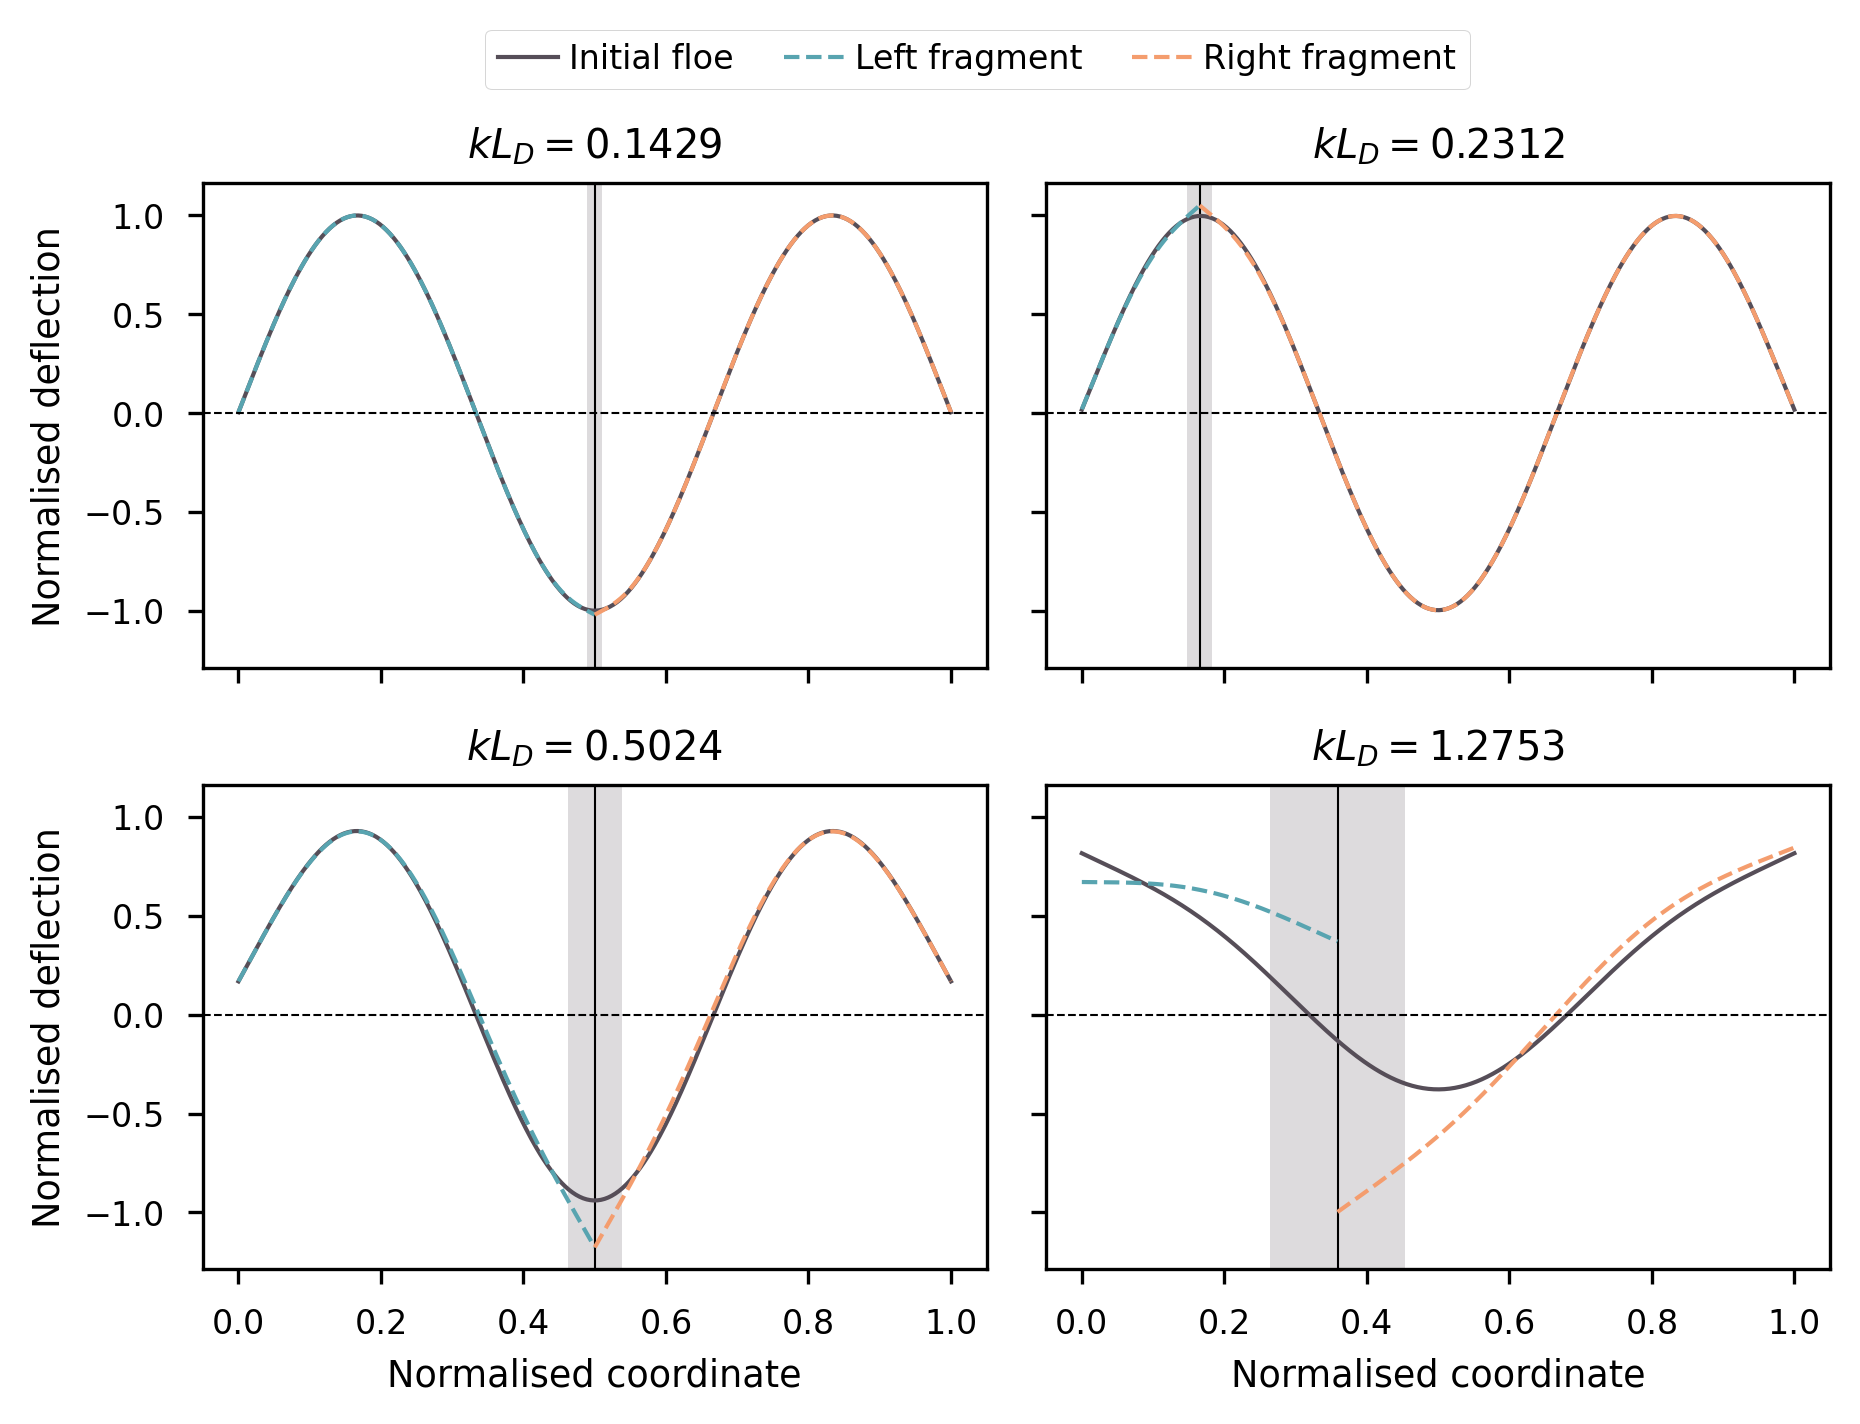

In [28]:
width = WIDTH_SINGLE_COLUMN
height = width / GR / .860
lw = 1

rest_lw = .65
defl_lw = .85
floe_fact = 1.25

with plt.style.context("seaborn-v0_8-paper"), sns.color_palette(colours):
    fig, axes = plt.subplots(2, 2, dpi=300, sharex=True, sharey=True, figsize=(width, height))
    
    for ax, idx in zip(np.ravel(axes), mid_idxs):
        wuf = WavesUnderFloe(
            left_edge=0,
            length=lengths[idx],
            wui=WavesUnderIce(floating_varnish, np.atleast_1d(wavenumbers[idx]), 0),
            edge_amplitudes=np.atleast_1d(amplitude_thresholds[idx]),
        )
        x = np.linspace(0, wuf.length, 400)
        w = wuf.displacement(x, None, True, None) / amplitude_thresholds[idx]

        nxf = normalised_fractures[idx]
        if nxf > .5:
            nxf = 1 - nxf
        xf = lengths[idx] * nxf
        wuf1, wuf2 = fracture_handler.split(wuf, xf)
        x1, x2 = (
            np.linspace(0, _wuf.length, np.ceil(_wuf.length / wuf.length).astype(int) * x.size)
            for _wuf in (wuf1, wuf2)
        )
        w1, w2 = (
            _wuf.displacement(_x, None, True, None) / amplitude_thresholds[idx]
            for _x, _wuf in zip((x1, x2), (wuf1, wuf2))
        )
        
        lb, rb = (
            np.array((-relaxation_lengths[idx], relaxation_lengths[idx]))
            / (2 * lengths[idx])
            + nxf
        )
        ax.axvspan(
            lb, rb, alpha=.2, facecolor="C3"
        )
        ax.axvline(nxf, lw=lw / 2, c="k")

        ax.plot(
            x / lengths[idx],
            w,
            color="C3",
            lw=lw,
            label="Initial floe"
        )
        ax.plot(
            x1 / wuf.length,
            w1,
            lw=lw,
            ls="--",
            label="Left fragment"
        )
        ax.plot(
            (x2 + wuf2.left_edge) / wuf.length,
            w2,
            lw=lw,
            ls="--",
            label="Right fragment"
        )
        ax.axhline(0, ls="--", lw=lw / 2, c="k")
        ax.set_title(f"$k L_D = {{{nondim[idx]:1.4f}}}$")
    
    for ax in axes[1, :]:
        ax.set_xlabel("Normalised coordinate")
    for ax in axes[:, 0]:
        ax.set_ylabel("Normalised deflection")

    handles, labels = ax.get_legend_handles_labels()
    
    plt.figlegend(
        handles=handles,
        labels=labels,
        ncols=3,
        handlelength=1.8,
        loc="upper center",
        bbox_to_anchor=(.525, 1.05),
        handletextpad=.33,
        columnspacing=1.5,
    )    
    
    fig.tight_layout()

    print([ax.bbox.width / ax.bbox.height for ax in np.ravel(axes)])
    # fig.savefig("different_regions_disp.pdf", bbox_inches="tight", dpi=fig.dpi)
        
    plt.show()
    plt.close()

# Asymptotic relaxation length

[ 7.30784097e-10  4.47320806e-10 -7.30783920e-10 -1.90888877e-09]
-1.0000002429448798 -0.23433571109001625 
 -0.9999998390989046

[8.40842658e-10]
rapport phase B/A: 1.6336912725438357

errors
1.3601852449672595e-17
-0.04228786547303569
-1.3997211499400673e-11
--
[-1.15189256e-10 -3.93014533e-10  1.15189254e-10  6.23393585e-10]
-1.0000000136339917 -0.6304436601241427 
 -1.0000023463390784

[-3.81241203e-10]
rapport phase B/A: 0.2930915925942053

errors
5.837743641477582e-18
0.009226884434961244
3.9162820432596836e-12
--
[-0.01453594  0.00677529  0.01453594  0.02229658]
-1.0000000000000262 0.3038711782489208 
 -1.0000000000000009

[0.00951403]
rapport phase B/A: -2.1448532226495796

errors
7.39323530983549e-17
-0.0681796269271894
0.00019779888277727316
--
[ 0.37034796 -0.75323333 -0.37034796  0.0125374 ]
-0.999999999999997 -60.07892001947538 
 -0.9999999999999957

[-1.02762061]
rapport phase B/A: -0.4878741883989929

errors
-3.029398132092168e-17
-0.03684923328680558
-0.0021721561178500

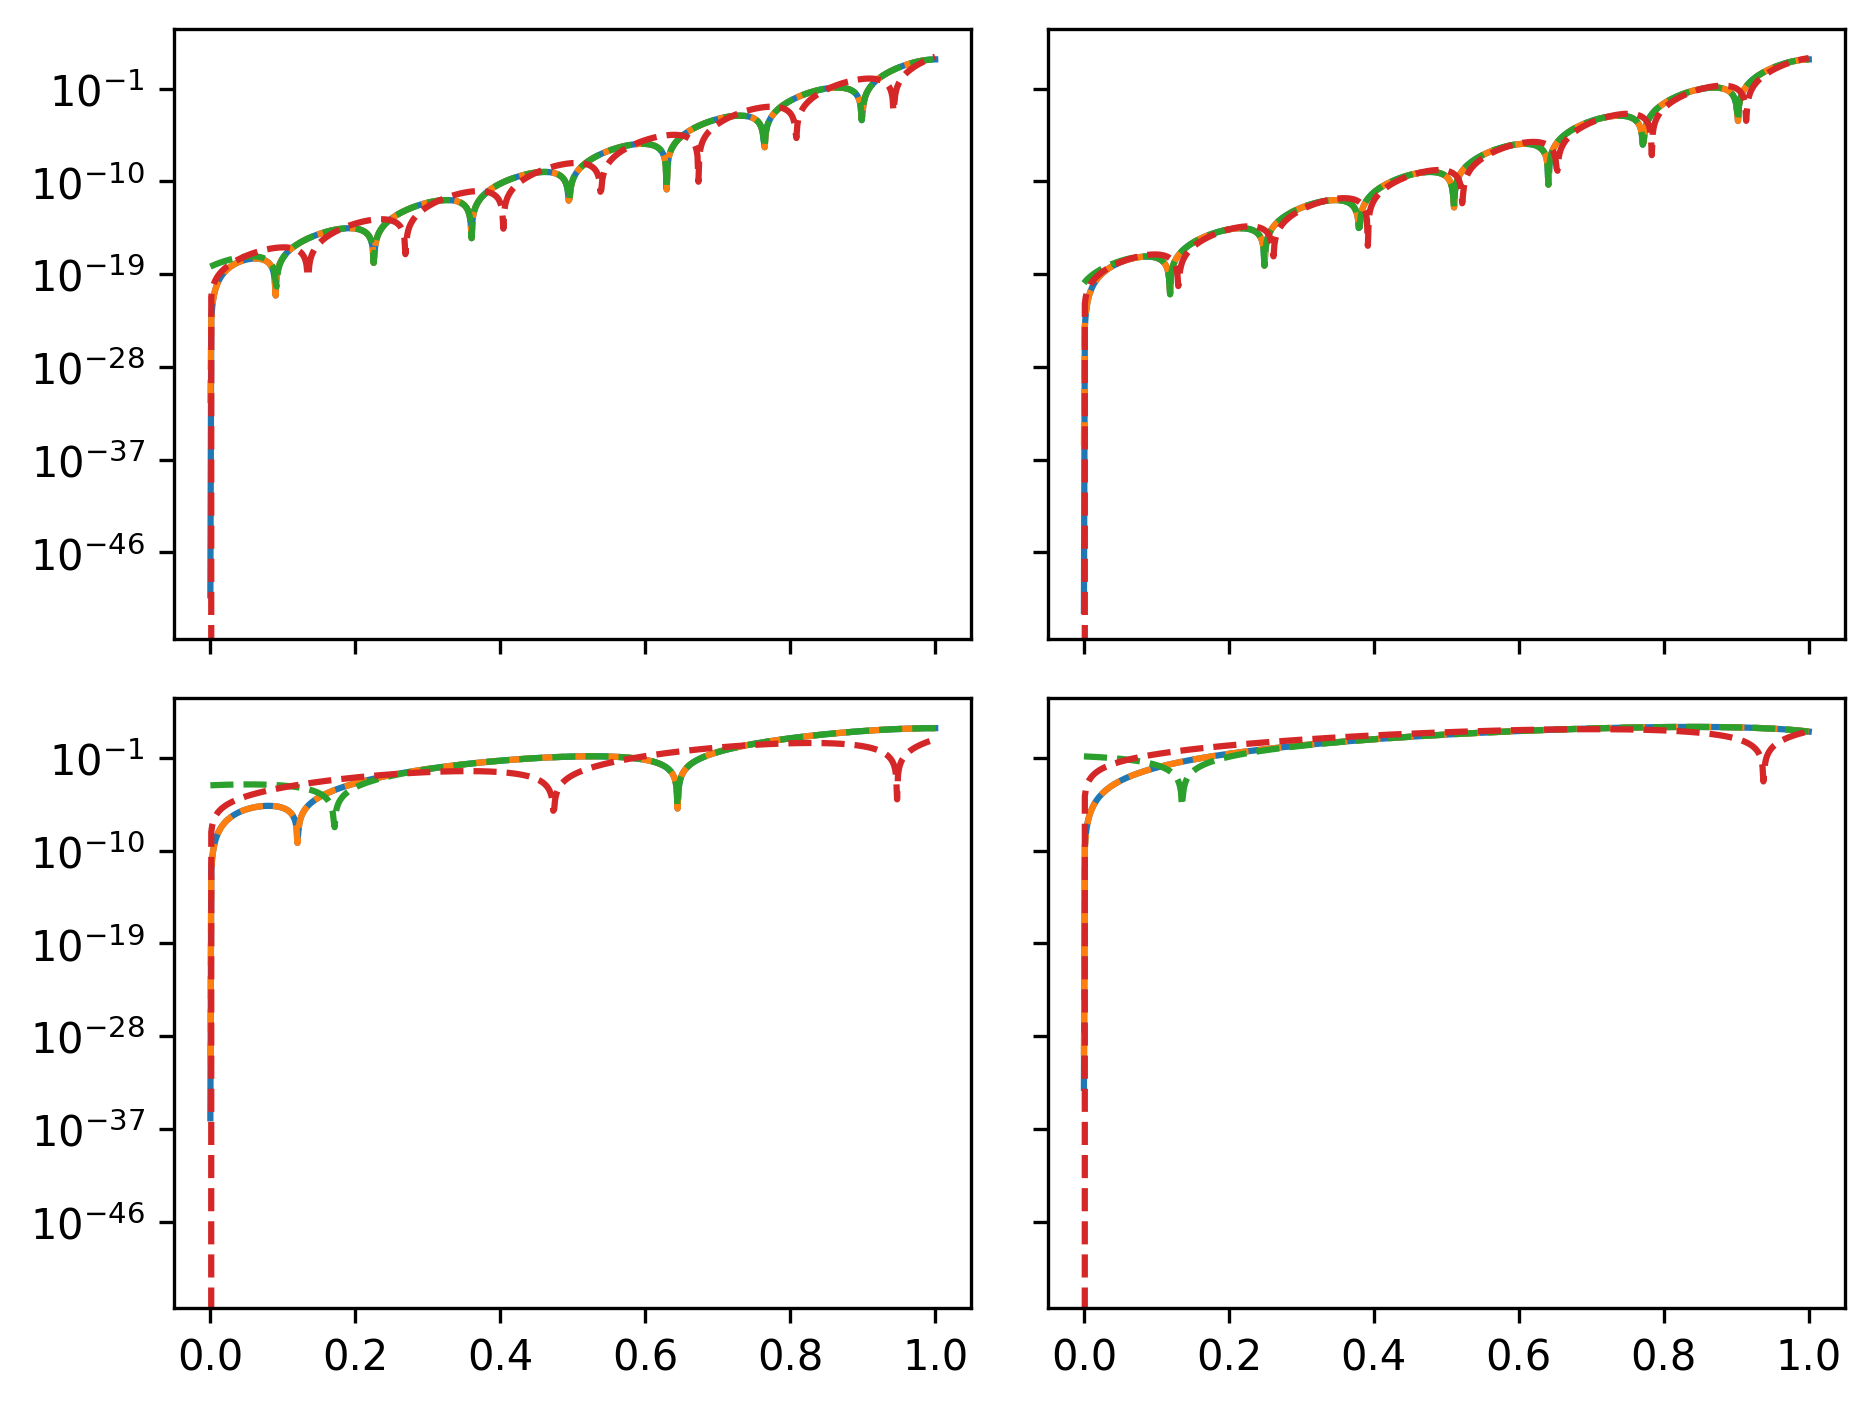

In [230]:
idx = mid_idxs[0]

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, dpi=300)

for idx, ax in zip(mid_idxs, np.ravel(axes)):
    wuf = WavesUnderFloe(
        left_edge=0,
        length=lengths[idx],
        wui=WavesUnderIce(floating_varnish, np.atleast_1d(wavenumbers[idx]), 0),
        edge_amplitudes=np.atleast_1d(amplitude_thresholds[idx]),
    )
    x = np.linspace(0, wuf.length, 800)
    w = wuf.displacement(x, None, True, None)
    curv = wuf.curvature(x, None, True, None)
    
    nxf = normalised_fractures[idx]
    if nxf < .5:
        nxf = 1 - nxf
    w1, w2 = fracture_handler.split(wuf, nxf * lengths[idx])
    xx = np.linspace(0, w1.length, 800)
    
    norm = wuf.wui.ice.elastic_length * np.sqrt(2)
    delta_curv = w1.curvature(xx, an_sol=True) - wuf.curvature(xx, an_sol=True)
    endog = delta_curv
    exog = np.vstack((
        np.cos(xx / norm) * np.exp(xx / norm),
        np.sin(xx / norm) * np.exp(xx / norm),
        np.cos(xx / norm) * np.exp(-xx / norm),
        np.sin(xx / norm) * np.exp(-xx / norm),
    )).T
    fit = sm.OLS(endog, exog).fit()
    fit_simple = sm.OLS(endog, exog[:, [1]]).fit()
    fit_simple_phase = sm.OLS(endog, exog[:, [0, 1]]).fit()

    ax.plot(
        xx / w1.length,
        delta_curv**2
    )
    ax.plot(xx / w1.length, fit.fittedvalues**2, "--")
    ax.plot(xx / w1.length, fit_simple_phase.fittedvalues**2, "--")
    ax.plot(xx / w1.length, fit_simple.fittedvalues**2, "--")
    
    ax.set_yscale("log")
    print(fit.params)
    print(
        fit.params[0] / fit.params[2], fit.params[1] / fit.params[3],
        "\n",
        (fit.params[1] + fit.params[3]) / (2 * fit.params[0])
    )
    print()
    print(fit_simple.params)
    print(f"rapport phase B/A: {fit_simple_phase.params[0] / fit_simple_phase.params[1]}")
    print()
    print("errors")
    print(np.trapz(delta_curv - fit.predict(), xx))
    print(np.trapz(delta_curv - fit_simple.predict(), xx))
    print(np.trapz(delta_curv - fit_simple_phase.predict(), xx))
    print("--")

fig.tight_layout()

plt.show()
plt.close()

In [228]:
fit_simple_phase.params[1] / fit_simple_phase.params[0]

-2.049708764633764

In [226]:
print(np.trapz(delta_curv - fit.predict(), xx))
print(np.trapz(delta_curv - fit_simple.predict(), xx))
print(np.trapz(delta_curv - fit_simple_phase.predict(), xx))

-3.029398132092168e-17
-0.03684923328680558
-0.002172156117850072


# Ice, flexural length and wave spectra

In [21]:
from flexfrac1d.model.model import Domain

In [12]:
def pierson_moskowitz(swh, angf, gravity=9.8):
    c1, c2 = 8.1e-3, 3.24e-2

    return c1 * gravity**2 / angf**5 * np.exp(-c2 * (gravity / (angf**2 * swh))**2)

In [58]:
frequencies = np.geomspace(.05, 2, 200)
angf = 2 * np.pi * frequencies
shws = np.linspace(1, 3, 5)
spec_dens = np.array([pierson_moskowitz(swh, angf) for swh in shws])
amps = np.array([np.sqrt(2 * _spec_dens[:-1] * np.ediff1d(angf)) for _spec_dens in spec_dens])

spectra = [DiscreteSpectrum(_amps, frequencies[:-1]) for _amps in amps]

In [71]:
gravity = 9.8

thickness = .5
youngs_modulus = 4e9
ice = Ice(thickness=thickness, youngs_modulus=youngs_modulus)
ocean = Ocean(depth=np.inf)
floe = Floe(left_edge=0, length=100, ice=ice)

domains = [Domain.from_discrete(gravity, spectrum, ocean) for spectrum in spectra]
for domain in domains:
    domain.add_floes(floe)

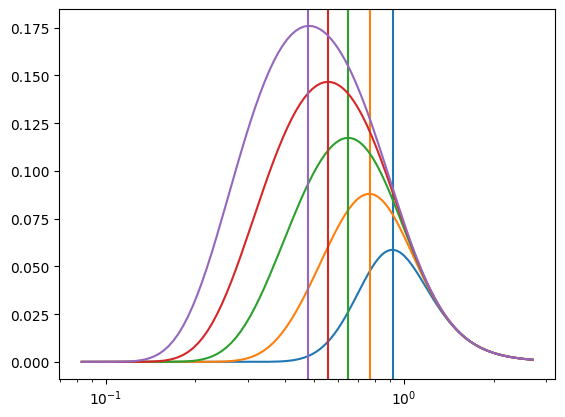

In [72]:
for i, domain in enumerate(domains):
    wuf = domain.subdomains[0]
    plt.plot(wuf.wui.ice.elastic_length * wuf.wui.wavenumbers, np.abs(wuf.edge_amplitudes))
    plt.axvline(wuf.wui.ice.elastic_length * wuf.wui.wavenumbers[np.argmax(np.abs(wuf.edge_amplitudes))], c=f"C{i}")
plt.xscale("log")
plt.show()
plt.close()

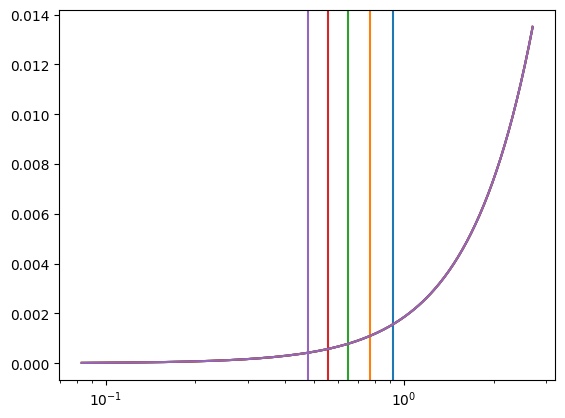

In [75]:
for i, domain in enumerate(domains):
    wuf = domain.subdomains[0]
    plt.plot(wuf.wui.ice.elastic_length * wuf.wui.wavenumbers, wuf.wui.attenuations)
    plt.axvline(wuf.wui.ice.elastic_length * wuf.wui.wavenumbers[np.argmax(np.abs(wuf.edge_amplitudes))], c=f"C{i}")
plt.xscale("log")
plt.show()
plt.close()